# vote_coefficients_0xAA40E2E5c8df03d792A52B5458959C320F86ca18_1


In [135]:
import os
from pathlib import Path
import numpy as np
import requests
import pandas as pd

from sbdata.FlipsideApi import FlipsideApi



# Set path to data folder
current_dir = Path(os.getcwd())
FOLDER_NAME = 'community_round'
CHAIN = 'optimism'
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', FOLDER_NAME)
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
GRANT_ROUND_ID = '0x984e29dCB4286c2D9cbAA2c238AfDd8A191Eefbc'
CHAIN_ID = '10'


# read the address from oss grant

api_key = os.environ['FLIPSIDE_API_KEY']
flipside_api = FlipsideApi(api_key, max_address=400)
PATH_TO_VOTES = os.path.join(DATA_DIR_GITCOIN, 'citizen-votes.csv')
# PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
# PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")
# PATH_TO_VOTES_GITCOIN = os.path.join(DATA_DIR_GITCOIN, CSV_GITCOIN_GRANTS)



In [136]:
# def load_round_votes_data(chain_id, round_id):
#     votes_url = 'https://indexer-grants-stack.gitcoin.co/data/' + chain_id + '/rounds/' + round_id + '/votes.json'
#     try:
#         # download the Votes JSON data from the URL
#         response = requests.get(votes_url)
#         if response.status_code == 200:
#             votes_data = response.json()
#         df = pd.DataFrame(votes_data)
#         return df
#     except:
#         return pd.DataFrame()

In [137]:
# # load data
# df_votes = df_votes = load_round_votes_data(CHAIN_ID, GRANT_ROUND_ID)

In [138]:
df_votes = pd.read_csv(PATH_TO_VOTES)
# df_grants = pd.read_csv(PATH_TO_GRANTS)
# df_application = pd.read_csv(PATH_TO_PROJECTS)
# Lowercase all addresses because flipside api return lowercase address
#id,projectId,applicationId,roundId,token,voter,grantAddress,amount,amountUSD,coefficient,status,last_score_timestamp,type,success,rawScore,threshold
# df_grants['Round ID'] = df_grants['Round ID'].str.lower()
# str_columns_votes = ['id', 'transaction', 'projectId', 'roundId', 'voter', 'grantAddress']
# df_votes[str_columns_votes] = df_votes[str_columns_votes].applymap(lambda x: x.lower())

# str_columns_application = ['id', 'roundId', 'metadata.application.round', 'metadata.application.recipient']
# df_application[str_columns_application] = df_application[str_columns_application].applymap(lambda x: str(x).lower())

# round_id = df_grants[df_grants['Round name'] == 'Web3 Community and Education']['Round ID'].values[0]
array_unique_address = df_votes['voter'].unique()

array_unique_address = np.char.lower(array_unique_address.astype(str))

In [139]:
from sbutils import LoadData

# Load data
data_loader = LoadData.LoadData(PATH_TO_EXPORT)
df_tx = data_loader.create_df_tx(CHAIN, array_unique_address)

In [140]:
df_tx.shape

(2822339, 10)

In [141]:
len(array_unique_address)

17023

In [142]:
df_tx.EOA.nunique()

17023

In [143]:
c = np.setxor1d(array_unique_address, df_tx.EOA.values)
c

array([], dtype=object)

## Computing legos booleans

In [144]:
from sblegos.TransactionAnalyser import TransactionAnalyser as txa
tx_analyser = txa(df_tx, df_address=pd.DataFrame(np.intersect1d(df_tx.EOA.unique(), array_unique_address), columns=['address']))

use matching address because some addresses are not in the extracted data set

In [145]:
df_matching_address = pd.DataFrame(df_tx.EOA.unique(), columns=["address"])
df_matching_address.head(2)

,address
0,0x000000006f457c0f8f560333d9c2877287d92a92
1,0x000128fa45d79dc9af8016da242781f12c363fd5


Compute the boolean 

less than 10 x transaction are not performant legos so we don't use it, has same seed is computed as an intermediarry to get the seed_suspicious flag

In [146]:
df_matching_address['seed_same_naive'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed_naive(x))
df_matching_address['seed_same'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_same_seed(x))
df_matching_address['seed_suspicious'] = df_matching_address.loc[:, 'seed_same_naive'].ne(df_matching_address.loc[:, 'seed_same'])
df_matching_address['less_5_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 5))
df_matching_address['less_10_tx'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_less_than_n_transactions(x, 10))

In [147]:
df_matching_address['interacted_other_ctbt'] = df_matching_address.loc[:, 'address'].apply(lambda x : tx_analyser.has_interacted_with_other_contributor(x))

In [148]:
df_matching_address['lcs'] = 0
r = df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'address'].apply(lambda x: tx_analyser.transaction_similitude_pylcs(x, minimum_sim_tx=3))

In [149]:
def lcs_to_array(lcs):
    if lcs.shape[0] == 0:
        return []
    else:
        return np.asarray(lcs.reset_index())

def get_mean_score_lcs(lcs):
    if lcs.shape[0] == 0:
        return 0
    else:
        return lcs.reset_index()['score'].mean()
    
def get_max_score_lcs(lcs):
    if lcs.shape[0] == 0:
        return 0
    else:
        return lcs.reset_index()['score'].max()
    
df_matching_address['cluster_size_lcs'] = 0
df_matching_address['mean_score_lcs'] = 0
df_matching_address['max_score_lcs'] = 0

df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'cluster_size_lcs'] = r.apply(lambda x: len(x))
df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'mean_score_lcs'] = r.apply(lambda x: get_mean_score_lcs(x))
df_matching_address.loc[df_matching_address['less_10_tx'] == True, 'max_score_lcs'] = r.apply(lambda x: get_max_score_lcs(x))

df_matching_address['has_lcs'] = df_matching_address['cluster_size_lcs'] > 0

print((df_matching_address[df_matching_address['less_10_tx'] == True]['cluster_size_lcs'] > 0).sum())

1082


In [150]:
print(f'Number of voters: {len(df_matching_address)}')

Number of voters: 17023


In [151]:
df_matching_address.sum()

address                  0x000000006f457c0f8f560333d9c2877287d92a920x00...
seed_same_naive                                                       7290
seed_same                                                            10999
seed_suspicious                                                       5229
less_5_tx                                                              910
less_10_tx                                                            2352
interacted_other_ctbt                                                 3315
lcs                                                                      0
cluster_size_lcs                                                     47991
mean_score_lcs                                                  157.549362
max_score_lcs                                                     184.4721
has_lcs                                                               1082
dtype: object

### Investigating the boolean seed suspicious

In [152]:
df_matching_address[df_matching_address['seed_suspicious'] == True]

,address,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs
2,0x000569d03483abb8949f729908465e65c4bdb243,False,True,True,False,True,False,0,57,0.194386,0.2,True
5,0x0017f7adf1b404298efa3015ca0b56961fea4c34,False,True,True,False,False,False,0,0,0.000000,0.0,False
6,0x001eabec5ae0e4dc40aecd9a75a6377fa0b31dcb,False,True,True,False,False,False,0,0,0.000000,0.0,False
8,0x002738a4a86d2591794fd36c120b36bad33d5f41,False,True,True,False,False,False,0,0,0.000000,0.0,False
12,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,False,True,True,False,False,False,0,0,0.000000,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
16999,0xffcb5e8b0ee83612b335f7011340983771a5f9c3,False,True,True,False,False,False,0,0,0.000000,0.0,False
17006,0xffd5c1af9951cf292e9386c89b8e08c92005c33b,False,True,True,False,False,False,0,0,0.000000,0.0,False
17007,0xffd92144cafd599a5a93e4805ca4d8f0e666d623,False,True,True,False,False,False,0,0,0.000000,0.0,False
17010,0xffe31b706e753e632667b46335f23b6adbb2ec6e,False,True,True,False,False,False,0,0,0.000000,0.0,False


### Computing the dex interaction score

In [153]:
def get_interacted_address(from_address, to_address, address):
    if from_address == address:
        return to_address
    else:
        return from_address

def count_interaction_with_any(tx_analyser, address, array_address):
    """
    Return an integer of the number of interactions with the addresses in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    count_interaction_with_any : int
        The number of interactions with the addresses in the array_address
    """
    tx_analyser.set_group_by_sorted_EOA()

    df = tx_analyser.gb_EOA_sorted.get_group(address)
    address_interacted = df.apply(lambda x: get_interacted_address(x['from_address'], x['to_address'], address), axis=1)
    tx_boolean_interacted = address_interacted.isin(array_address)
    return tx_boolean_interacted.sum()

def has_interacted_with_any(tx_analyser, address, array_address):
    """
    Return a boolean whether the address has interacted with any address in the array_address
    Parameters
    ----------
    address : str
        The address to check

    Returns
    -------
    has_interacted_with_any : bool
        True if the address has interacted with one or more of the addresses in the array_address
    """
    count_interaction_with_any = count_interaction_with_any(tx_analyser, address, array_address)
    return count_interaction_with_any > 0

In [154]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='optimism'
AND LABEL_SUBTYPE = 'pool' 
;'''
df_label = flipside_api.execute_query(label_query)

In [155]:
# extract all the pool addresses
array_pool_address = df_label['address'].unique()

In [156]:
tx_analyser.set_group_by_sorted_EOA()

In [157]:
# Compute the number of interactions with any of the pools for each address
df_matching_address['count_interaction_with_pool'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, array_pool_address))

In [158]:
(df_matching_address['count_interaction_with_pool'] > 0).sum() / len(df_matching_address)

0.496974681313517

From these tags lets flag any address that have interacted with a toxic wallet

In [159]:
label_query = '''
SELECT ADDRESS, CREATOR, LABEL_TYPE, ADDRESS_NAME, PROJECT_NAME
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='optimism'
AND LABEL_SUBTYPE = 'toxic'
;'''
df_toxic = flipside_api.execute_query(label_query)

In [160]:
df_toxic.shape

(0, 0)

In [162]:
# Compute the number of interactions with any of the scam for each address
if df_toxic.shape[0] > 0:
    df_matching_address['count_interaction_with_toxic'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_toxic['address'].unique()))
else:
    df_matching_address['count_interaction_with_toxic'] = 0

In [163]:
print(f'Percentage of addresses that have interacted with a toxic address: {int((df_matching_address["count_interaction_with_toxic"] > 0).sum() / len(df_matching_address) *100)}%')

Percentage of addresses that have interacted with a toxic address: 0%


I found the tag_name "airdrop master" could be interesting 

In [182]:
query_airdrop_master = '''
SELECT BLOCKCHAIN, CREATOR, ADDRESS, TAG_NAME
FROM crosschain.core.address_tags 
WHERE TAG_NAME = 'airdrop master'
;
'''
df_airdrop_master = flipside_api.execute_query(query_airdrop_master)

In [183]:
df_airdrop_master

,blockchain,creator,address,tag_name,__row_index
0,ethereum,flipside,0x366b862656d5f06d506d6fc2c1e31425c2ccfc3f,airdrop master,0
1,ethereum,flipside,0x1637c6985673c6b92b2c97faf4f9dfec7a77ee25,airdrop master,1
2,ethereum,flipside,0xf1c0dc910ecfb7260e97e79d9e89774dca231456,airdrop master,2
3,ethereum,flipside,0xe92156af7db06361a508f3c2fc4a382edb9ee2b0,airdrop master,3
4,ethereum,flipside,0x39f234a6ef150346e887a036c4ea1642e26e87ec,airdrop master,4
...,...,...,...,...,...
65533,ethereum,flipside,0xc85b0b3dc93e6be5a15df75f89acc6855cbf4252,airdrop master,165533
65534,ethereum,flipside,0x7da9949382c0f36700b563712ff0a6e38374aa92,airdrop master,165534
65535,ethereum,flipside,0x1b84fd3a36bd551da54d9d5607885f1461ee9dc6,airdrop master,165535
65536,ethereum,flipside,0x2fb27655744ffd73ef90e42dc2f56591be58d4d3,airdrop master,165536


In [184]:
# Compute the number of interactions with any of the aidrop for each address
df_matching_address['count_interaction_with_airdrop_m'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_airdrop_master['address'].unique()))
print(f'Percentage of addresses that interacted with airdrop master: {int((df_matching_address["count_interaction_with_airdrop_m"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with airdrop master: 3%


In [185]:
# Boolean whether the address is a aidrop master
df_matching_address['is_airdrop_master'] = df_matching_address['address'].apply(lambda x: x in df_airdrop_master['address'].unique()) 
print(f'Percentage of addresses that are airdrop master: {int((df_matching_address["is_airdrop_master"]).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that are airdrop master: 4%


In [186]:
sql_query_tornado = '''
SELECT DISTINCT PROJECT_NAME, ADDRESS
FROM crosschain.core.address_labels 
WHERE BLOCKCHAIN='optimism'
AND PROJECT_NAME LIKE '%tornado%'
;
'''
df_tornado = flipside_api.execute_query(sql_query_tornado)

In [187]:
# Count the number of interactions with tornado
df_matching_address['count_interaction_with_tornado'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, df_tornado['address'].unique()))
print(f'Percentage of addresses that interacted with tornado: {int((df_matching_address["count_interaction_with_tornado"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with tornado: 1%


In [188]:
# Count the number of time the address interatec with disperse contract: '0xD152f549545093347A162Dce210e7293f1452150'
df_matching_address['count_interaction_with_disperse'] = df_matching_address['address'].apply(lambda x: count_interaction_with_any(tx_analyser, x, [str.lower('0xD152f549545093347A162Dce210e7293f1452150')]))
print(f'Percentage of addresses that interacted with disperse: {int((df_matching_address["count_interaction_with_disperse"] > 0).sum() / len(df_matching_address) * 100)}%')

Percentage of addresses that interacted with disperse: 0%


In [189]:
df_matching_address.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,count_interaction_with_pool,count_interaction_with_toxic,count_interaction_with_airdrop_m,count_interaction_with_tornado,count_interaction_with_disperse
count,17023.0,17023.000000,17023.000000,17023.000000,17023.000000,17023.0,17023.000000,17023.000000,17023.000000
mean,0.0,2.819186,0.009255,0.010837,6.257240,0.0,0.142807,0.020795,0.005463
std,0.0,18.442207,0.036681,0.042714,16.397703,0.0,1.620024,0.171839,0.208290
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
10%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,4.000000,0.0,0.000000,0.000000,0.000000
90%,0.0,0.000000,0.000000,0.000000,22.000000,0.0,0.000000,0.000000,0.000000
max,0.0,328.000000,0.200000,0.200000,1010.000000,0.0,85.000000,5.000000,21.000000


In [190]:
df_matching_address['has_interaction_toxic'] = df_matching_address['count_interaction_with_toxic'] > 0
df_matching_address['has_no_pool_interaction'] = df_matching_address['count_interaction_with_pool'] < 6
df_matching_address['has_interaction_airdrop_m'] = df_matching_address['count_interaction_with_airdrop_m'] > 0
df_matching_address['has_interaction_tornado'] = df_matching_address['count_interaction_with_tornado'] > 0
df_matching_address['has_interaction_disperse'] = df_matching_address['count_interaction_with_disperse'] > 0

In [191]:
boolean_features = ['has_lcs', 'seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_airdrop_m', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'interacted_other_ctbt']

In [192]:
df_matching_address[boolean_features].sum() 

has_lcs                       1082
seed_suspicious               5229
has_interaction_toxic            0
has_no_pool_interaction      13413
has_interaction_airdrop_m      591
has_interaction_tornado        298
has_interaction_disperse        37
is_airdrop_master              728
interacted_other_ctbt         3315
dtype: int64

In [193]:
len(df_matching_address)

17023

### Look at the addresses with at least one flag

We are going to review the addresses that have at least 1 flag:
- has_intercation_toxic 
- has_interaction_disperse
- has_interaction_airdrop_master
- is airdrop master
- interacted with other contributor and less than 5 tx
- has_lcs

remove seed suspicious because many people use bridges to fund their wallet

I decided to remove tornado cash because someone can be anonimous with out being a sybil

In [194]:
df_matching_address['interact_less_5tx'] = np.logical_and(df_matching_address['interacted_other_ctbt'], df_matching_address['less_5_tx'])

In [195]:
interaction_bool = ['has_lcs', 'has_interaction_toxic', 'has_interaction_airdrop_m', 'has_interaction_disperse', 'is_airdrop_master', 'interact_less_5tx']

In [196]:
df_matching_address[interaction_bool].sum()

has_lcs                      1082
has_interaction_toxic           0
has_interaction_airdrop_m     591
has_interaction_disperse       37
is_airdrop_master             728
interact_less_5tx              34
dtype: int64

In [197]:
from scipy.spatial.distance import pdist

def jaccard_similarity_matrix(df):
    
    n = df.shape[1]
    scores = 1 - pdist(np.array(df).T, metric='jaccard')
    result = np.zeros((n,n))
    result[np.triu_indices(n, k=1)] = scores
    result += result.T
    np.fill_diagonal(result, 1)
    return pd.DataFrame(result, index=df.columns, columns=df.columns)

jaccard_similarity = jaccard_similarity_matrix(df_matching_address[interaction_bool])
jaccard_similarity

,has_lcs,has_interaction_toxic,has_interaction_airdrop_m,has_interaction_disperse,is_airdrop_master,interact_less_5tx
has_lcs,1.000000,0.0,0.002397,0.000000,0.002215,0.001795
has_interaction_toxic,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
has_interaction_airdrop_m,0.002397,0.0,1.000000,0.000000,0.157018,0.003210
has_interaction_disperse,0.000000,0.0,0.000000,1.000000,0.002621,0.000000
is_airdrop_master,0.002215,0.0,0.157018,0.002621,1.000000,0.000000
interact_less_5tx,0.001795,0.0,0.003210,0.000000,0.000000,1.000000


<Axes: >

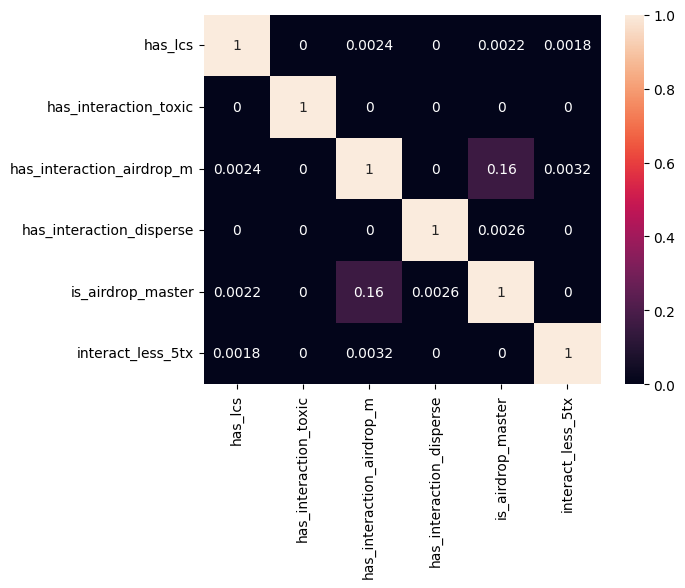

In [198]:
import seaborn as sns
sns.heatmap(jaccard_similarity, annot=True)

In [199]:
df_matching_address['flagged'] = df_matching_address[interaction_bool].sum(axis=1) > 0
df_interact_sus_2 = df_matching_address[df_matching_address['flagged'] == True]
print(f'Number of addresses that interacted with a suspicious contract or address: {df_interact_sus_2.shape[0]}')

Number of addresses that interacted with a suspicious contract or address: 2282


In [200]:
boolean_to_keep = ['has_lcs', 'seed_suspicious', 'has_interaction_toxic', 'has_no_pool_interaction', 'has_interaction_tornado', 'has_interaction_disperse', 'is_airdrop_master', 'has_interaction_airdrop_m', 'interacted_other_ctbt', 'interact_less_5tx', 'flagged']

In [201]:
df_matching_address[boolean_to_keep].sum()

has_lcs                       1082
seed_suspicious               5229
has_interaction_toxic            0
has_no_pool_interaction      13413
has_interaction_tornado        298
has_interaction_disperse        37
is_airdrop_master              728
has_interaction_airdrop_m      591
interacted_other_ctbt         3315
interact_less_5tx               34
flagged                       2282
dtype: int64

In [202]:
final_merge = df_votes.merge(df_matching_address, left_on='voter', right_on='address', how='left')
print(f'number of squelched votes out of {final_merge.shape[0]}')
final_merge[['flagged']].sum() 

number of squelched votes out of 57366


flagged    8626
dtype: int64

In [203]:
print(df_votes.shape)
print(final_merge.shape)

(57366, 6)
(57366, 31)


C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_12448\3488879250.py:7: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))


(81811, 19) votes stephi
(57366, 31) final merge
(57366, 33) votes merge


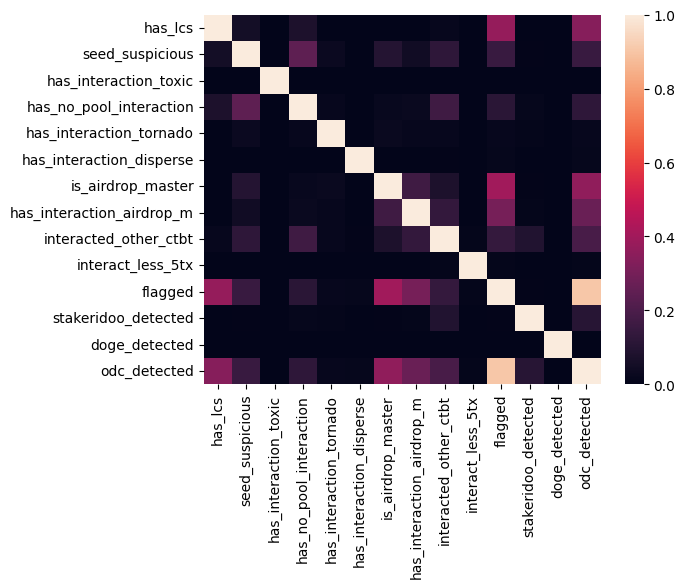

In [204]:
# Adding Stakeriddo and Gray flagged wallet

DATA_DIR_STEFI = os.path.join(current_dir.parent.parent, 'stefi')
CSV_STEPHI = 'sso_odc_analysis.csv'

# load data
df_votes_stephi = pd.read_csv(os.path.join(DATA_DIR_STEFI, CSV_STEPHI))
print(f'{df_votes_stephi.shape} votes stephi')
print(f'{final_merge.shape} final merge')
df_stephi_bool_voter = df_votes_stephi[['voter', 'stakeridoo_detected', 'doge_detected']]
df_merge = final_merge.merge(df_stephi_bool_voter.drop_duplicates(subset=['voter']), left_on='voter', right_on='voter', how='left')
print(f'{df_merge.shape} votes merge')

df_merge['stakeridoo_detected'].fillna(False, inplace=True)
df_merge['doge_detected'].fillna(False, inplace=True)
df_merge['odc_detected'] = np.logical_or(np.logical_or(df_merge['stakeridoo_detected'], df_merge['doge_detected']), df_merge['flagged'])

boolean_jaccard = boolean_to_keep + ['stakeridoo_detected', 'doge_detected', 'odc_detected']
jaccard_similarity_2 = jaccard_similarity_matrix(df_merge[boolean_jaccard])
sns.heatmap(jaccard_similarity_2)

df_merge.drop(columns=['address']).to_csv(f'../output_gitcoin/n_{CHAIN_ID}_{GRANT_ROUND_ID}.csv', index=False)

In [209]:
df_merge.drop(columns=['address']).to_csv(f'../output_gitcoin/n_{CHAIN_ID}_{GRANT_ROUND_ID}.csv', index=False)

In [213]:
df_merge.drop_duplicates(subset=['voter'])[boolean_jaccard].sum(axis=0)

has_lcs                       1082
seed_suspicious               5229
has_interaction_toxic            0
has_no_pool_interaction      13413
has_interaction_tornado        298
has_interaction_disperse        37
is_airdrop_master              728
has_interaction_airdrop_m      591
interacted_other_ctbt         3315
interact_less_5tx               34
flagged                       2282
stakeridoo_detected            136
doge_detected                    2
odc_detected                  2407
dtype: int64

In [214]:
df_merge.drop_duplicates(subset=['voter']).shape

(17023, 34)

In [215]:
df_matching_address[boolean_to_keep].sum()

has_lcs                       1082
seed_suspicious               5229
has_interaction_toxic            0
has_no_pool_interaction      13413
has_interaction_tornado        298
has_interaction_disperse        37
is_airdrop_master              728
has_interaction_airdrop_m      591
interacted_other_ctbt         3315
interact_less_5tx               34
flagged                       2282
dtype: int64

In [205]:
df_merge[boolean_jaccard].sum(axis=0)

has_lcs                       3223
seed_suspicious              18907
has_interaction_toxic            0
has_no_pool_interaction      41794
has_interaction_tornado       1342
has_interaction_disperse       128
is_airdrop_master             3463
has_interaction_airdrop_m     2606
interacted_other_ctbt        10720
interact_less_5tx              101
flagged                       8626
stakeridoo_detected            983
doge_detected                    6
odc_detected                  9558
dtype: int64

In [222]:
df_merge[df_merge['has_lcs'] == True].groupby('project').first().sort_values(by='voter', ascending=False)

,block_timestamp,tx_hash,voter,amount_usd,__row_index,address,seed_same_naive,seed_same,seed_suspicious,less_5_tx,...,is_airdrop_master,count_interaction_with_tornado,count_interaction_with_disperse,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,flagged,stakeridoo_detected,doge_detected,odc_detected
project,,,,,,,,,,,,,,,,,,,,,
0x91fbd3447077bfd97f5af4d2c033ecbc25788f89,2023-06-27T23:14:59.000Z,0xd30bb8483147faa7e53a7f374a32dcbaa404985032dd...,0xf06107faa1398fc800e00ad974e3a5b617e8e542,0.377385,223,0xf06107faa1398fc800e00ad974e3a5b617e8e542,True,True,False,False,...,False,0,0,False,False,False,True,False,False,True
0x8d36bbb74973dd04e31dcbce5778b16dd310bd9b,2023-06-27T23:14:59.000Z,0xd30bb8483147faa7e53a7f374a32dcbaa404985032dd...,0xf06107faa1398fc800e00ad974e3a5b617e8e542,0.382646,232,0xf06107faa1398fc800e00ad974e3a5b617e8e542,True,True,False,False,...,False,0,0,False,False,False,True,False,False,True
0xf55d40d1e5255a639ab36834f93d44ce8125e047,2023-06-27T23:14:59.000Z,0xd30bb8483147faa7e53a7f374a32dcbaa404985032dd...,0xf06107faa1398fc800e00ad974e3a5b617e8e542,0.390637,224,0xf06107faa1398fc800e00ad974e3a5b617e8e542,True,True,False,False,...,False,0,0,False,False,False,True,False,False,True
0xdc71a1bdeabd3c347dc21e9354aff91ad375eb97,2023-06-27T23:14:59.000Z,0xd30bb8483147faa7e53a7f374a32dcbaa404985032dd...,0xf06107faa1398fc800e00ad974e3a5b617e8e542,0.386126,229,0xf06107faa1398fc800e00ad974e3a5b617e8e542,True,True,False,False,...,False,0,0,False,False,False,True,False,False,True
0xca72c93172ba6eff168e59e7f17c3c7a8fea9b62,2023-06-27T23:14:59.000Z,0xd30bb8483147faa7e53a7f374a32dcbaa404985032dd...,0xf06107faa1398fc800e00ad974e3a5b617e8e542,0.394020,220,0xf06107faa1398fc800e00ad974e3a5b617e8e542,True,True,False,False,...,False,0,0,False,False,False,True,False,False,True
0xc4450c8d1009160883e44f24d66d92436ae4b4c5,2023-06-27T23:14:59.000Z,0xd30bb8483147faa7e53a7f374a32dcbaa404985032dd...,0xf06107faa1398fc800e00ad974e3a5b617e8e542,0.382047,242,0xf06107faa1398fc800e00ad974e3a5b617e8e542,True,True,False,False,...,False,0,0,False,False,False,True,False,False,True
0xbec643bd5b7f5e9190617ca4187ef0455950c51c,2023-06-27T23:14:59.000Z,0xd30bb8483147faa7e53a7f374a32dcbaa404985032dd...,0xf06107faa1398fc800e00ad974e3a5b617e8e542,0.382630,241,0xf06107faa1398fc800e00ad974e3a5b617e8e542,True,True,False,False,...,False,0,0,False,False,False,True,False,False,True
0xb62e762af637b49eb4870bce8fe21bfff189e495,2023-06-27T23:14:59.000Z,0xd30bb8483147faa7e53a7f374a32dcbaa404985032dd...,0xf06107faa1398fc800e00ad974e3a5b617e8e542,0.378028,239,0xf06107faa1398fc800e00ad974e3a5b617e8e542,True,True,False,False,...,False,0,0,False,False,False,True,False,False,True
0xa51e0a99b53d5b00937a2631d5865468a3543b7d,2023-06-27T23:14:59.000Z,0xd30bb8483147faa7e53a7f374a32dcbaa404985032dd...,0xf06107faa1398fc800e00ad974e3a5b617e8e542,0.382066,238,0xf06107faa1398fc800e00ad974e3a5b617e8e542,True,True,False,False,...,False,0,0,False,False,False,True,False,False,True


In [207]:
df_merge[df_merge['has_lcs'] == True].sort_values("max_score_lcs").voter.unique()

array(['0x310e17aac11fc520fe1cca063d33eb31a59d0034',
       '0x8270a0febba70899419e76a98bf2b5dc15fe2ff4',
       '0x0b32165db4d078ced10e75cc069b92ce2a049827', ...,
       '0x33f3e6a6800a4cdad0def04f943b4c1a296df8b9',
       '0x2ca482f7de7075b5800c813741951b7a196b247e',
       '0x202dd5ed1fd4158d013bf38daea7f8e6d9df24a7'], dtype=object)

In [224]:
df_matching_address_lcs = df_matching_address[df_matching_address['has_lcs']]
df_matching_address_lcs.shape

(1082, 25)

In [234]:
df_matching_address_lcs['lcs'].unique()

array([0], dtype=int64)

In [243]:
c1 = r.reset_index().address[0].index.values

In [244]:
df_tx_lcs = df_tx[df_tx['EOA'].isin(c1)]

In [245]:
# create network graph
import networkx as nx
G = nx.from_pandas_edgelist(df_tx_lcs, source='from_address', target='to_address', edge_attr=True, create_using=nx.DiGraph())


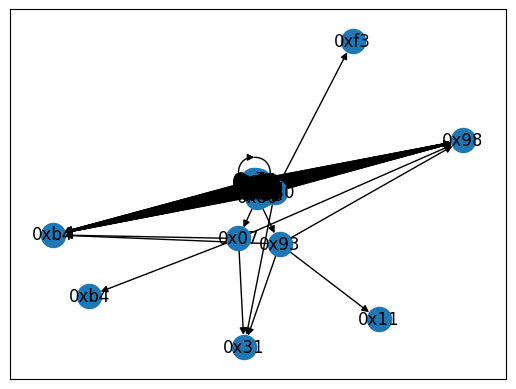

In [275]:
from matplotlib import pyplot as plt
# Create a dictionary to store the node labels
labels = {}
colors = []
# Set the node labels to display only the first 4 characters
for node in G.nodes():
    labels[node] = node[:4]
    if node in df_votes['voter'].unique():
        colors.append('red')
    elif node == "0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc":
        colors.append('green')
    else:
        colors.append('blue')

# Plot the graph
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, labels=labels, with_labels=True)
plt.show()

In [276]:
import plotly.graph_objects as go


# Create a list to store the node positions
pos = nx.spring_layout(G)

# Create a Scatter plot for the nodes
node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers',
    text=[labels[node] for node in G.nodes()],
    hoverinfo='text',
    marker=dict(
        size=15,
        color=colors
    )
)

# Create a list to store the edge traces
edge_traces = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
        x=[x0, x1],
        y=[y0, y1],
        mode='lines',
        line=dict(width=1),
        hoverinfo='none'
    )
    edge_traces.append(edge_trace)

# Create the figure
fig = go.Figure(data=[*edge_traces, node_trace])

# Set the layout options
fig.update_layout(
    plot_bgcolor='white',
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    margin=dict(b=20, l=5, r=5, t=40),
    hovermode='closest'
)

# Show the figure
fig.show()


In [255]:
print(G.number_of_nodes())
print(G.number_of_edges())
print(nx.is_directed(G))
G.nodes()

64
178
True


NodeView(('0x0301f541ae4216a0b04fa52c6a34d7a58d21d692', '0xb49c4e680174e331cb0a7ff3ab58afc9738d5f8b', '0x80c67432656d59144ceff962e8faf8926599bcf8', '0x984e29dcb4286c2d9cbaa2c238afdd8a191eefbc', '0x05a3293973cff2fef1cf30a9c58c5b5b4419c972', '0x05c2c1d0c3cf0134987191c28707352284d3bd3e', '0x071312888bfeb39664c557dbe3a7480a0f77f1ad', '0xb436dfe922eda09d02f8b27551b0f3daf438447b', '0x31f88a359a045aba182a3e1d05ceaa5a5b0f5912', '0x0c9a583cf49037cd060e7155b58700d8d1c75486', '0x0ca95a247da8882a27c57c53aff3aa885b805e9f', '0x0ceaf90efd1d3b2a2e024a0a82376c1901d178a5', '0x1144e5b48e30ef24df1b63454edc506501d3bc7a', '0x15ef9388097466e70d603e4fb96c664a178d38f9', '0x29149ec0963ce0b1a3394ebec493ce7cbb6f8e25', '0x2e1168d4d36e9233cfb3a2d7fc5816126facedca', '0x30ea70ebcb3d9349b9736462890a886a58ca7518', '0xf3f48cb2f7ecc25f17de2f5194cb77a6edc7c942', '0x33f3e6a6800a4cdad0def04f943b4c1a296df8b9', '0x38526a24612ea289ecb990692514a40767c730ad', '0x3a69a5fbe5eff43517ae1c57c34e6fece169c9c6', '0x3a6d43db16a611fd175b0

In [228]:
# create network graph
import networkx as nx
G = nx.from_pandas_edgelist(df_tx_lcs, source='from_address', target='to_address', edge_attr=True, create_using=nx.DiGraph())


In [229]:
G.number_of_nodes()

1358

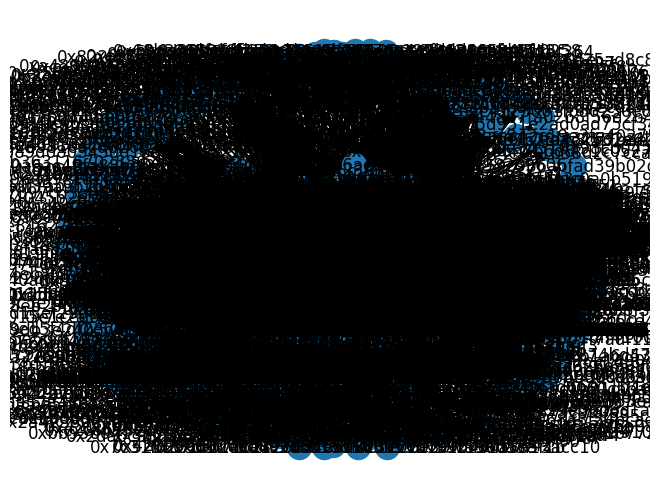

In [231]:
# print graph 
nx.draw(G, with_labels=True)

In [208]:
df_merge[df_merge['has_lcs'] == True].grantAddress.describe()   

AttributeError: 'DataFrame' object has no attribute 'grantAddress'

In [ ]:
df_application.columns

NameError: name 'df_application' is not defined

In [ ]:
df_application[df_application["metadata.application.project.title"].str.lower().str.contains('jedi')]["metadata.application.recipient"]

19    0x18aa467e40e1defb1956708830a343c1d01d3d7c
Name: metadata.application.recipient, dtype: object

In [ ]:
jedi_swap = df_merge[df_merge['grantAddress'].str.lower() == str.lower('0x18aa467E40E1deFB1956708830A343c1D01d3D7C')]

In [ ]:
jedi_swap['voter'].nunique()

9506

In [ ]:
jedi_swap['voter'].shape

(9710,)

In [ ]:
jedi_swap.columns

Index(['id', 'projectId', 'applicationId', 'roundId', 'token', 'voter',
       'grantAddress', 'amount', 'amountUSD', 'coefficient', 'status',
       'last_score_timestamp', 'type', 'success', 'rawScore', 'threshold',
       'address', 'seed_same_naive', 'seed_same', 'seed_suspicious',
       'less_5_tx', 'less_10_tx', 'interacted_other_ctbt', 'lcs',
       'cluster_size_lcs', 'mean_score_lcs', 'max_score_lcs', 'has_lcs',
       'count_interaction_with_pool', 'count_interaction_with_toxic',
       'count_interaction_with_airdrop_m', 'is_airdrop_master',
       'count_interaction_with_tornado', 'count_interaction_with_disperse',
       'has_interaction_toxic', 'has_no_pool_interaction',
       'has_interaction_airdrop_m', 'has_interaction_tornado',
       'has_interaction_disperse', 'interact_less_5tx', 'flagged',
       'stakeridoo_detected', 'doge_detected', 'bool_gitcoin_detected',
       'odc_detected', 'proposed_coeff'],
      dtype='object')

In [ ]:
jedi_swap[["odc_detected", "stakeridoo_detected", "doge_detected", "bool_gitcoin_detected", "is_airdrop_master", "has_interaction_toxic", "has_no_pool_interaction", "has_interaction_airdrop_m", "has_interaction_tornado", "has_interaction_disperse", "interact_less_5tx", "has_lcs"]].sum()

odc_detected                 2374
stakeridoo_detected           449
doge_detected                  32
bool_gitcoin_detected         222
is_airdrop_master             567
has_interaction_toxic         187
has_no_pool_interaction      8440
has_interaction_airdrop_m    1355
has_interaction_tornado        84
has_interaction_disperse      113
interact_less_5tx               5
has_lcs                       167
dtype: int64

In [ ]:
df_no_lcs= pd.read_csv(os.path.join('C:\\Users\\DELL Admin\\Downloads\\Telegram Desktop', f"n_{CSV_GITCOIN_GRANTS}"))

C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_9816\525363702.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_no_lcs= pd.read_csv(os.path.join('C:\\Users\\DELL Admin\\Downloads\\Telegram Desktop', f"n_{CSV_GITCOIN_GRANTS}"))


In [ ]:
bool_old = set(boolean_jaccard) - set(['has_lcs', 'bool_gitcoin_detected'])
bool_old = list(bool_old)

In [ ]:
df_no_lcs[bool_old].sum(axis=0)

is_airdrop_master             5230
has_no_pool_interaction      69503
stakeridoo_detected           3527
has_interaction_tornado       1271
seed_suspicious               2319
has_interaction_toxic         1763
has_interaction_airdrop_m    12198
interacted_other_ctbt        22821
odc_detected                 19274
interact_less_5tx               83
has_interaction_disperse      1192
flagged                      16274
doge_detected                  215
dtype: int64

In [ ]:
19274 - 20753

-1479

In [ ]:
df_lcs_top_grant = df_merge[df_merge['has_lcs'] == True].groupby('grantAddress')['voter'].count().sort_values(ascending=False).reset_index()
df_lcs_top_grant.head(10)

,grantAddress,voter
0,0x3a5bd1e37b099ae3386d13947b6a90d97675e5e3,197
1,0x18aa467e40e1defb1956708830a343c1d01d3d7c,167
2,0x08a3c2a819e3de7aca384c798269b3ce1cd0e437,159
3,0x99b36fdbc582d113af36a21eba06bfeab7b9be12,157
4,0xdb0c831283c003686aef40ca228e42bdabf6674c,136
5,0x5683921269b041fbe66882dd6cadd48b7e5b5817,127
6,0xe126b3e5d052f1f575828f61feba4f4f2603652a,77
7,0x4b8810b079eb22ecf2d1f75e08e0abbd6fd87dbf,70
8,0x01d79bceaeaadfb8fd2f2f53005289cfcf483464,62
9,0x57ea12a3a8e441f5fe7b1f3af1121097b7d3b6a8,61


In [ ]:
df_application['metadata.application.project.title']

In [ ]:
df_application.merge(df_lcs_top_grant, left_on='metadata.application.recipient', right_on='grantAddress', how='left').sort_values(by='voter', ascending=False)['metadata.application.project.title'].head(10)

10                                           Lenster
19                                          JediSwap
167                                        Chainlist
24                                         DefiLlama
87     Taho - Open Source and Community Owned Wallet
105                           Leto | Transfer crypto
104                         Via | Cross-chain router
73                                           OmniBTC
14       Revoke.cash - Helping you stay safe in web3
100         BrightID 🔆 Universal Proof of Uniqueness
Name: metadata.application.project.title, dtype: object

In [ ]:
df_merge.drop_duplicates(subset=["voter"])['has_no_pool_interaction'].value_counts()

has_no_pool_interaction
True     12670
False     1884
Name: count, dtype: int64

In [ ]:
df_stake = df_merge.drop_duplicates(subset=["voter"])[df_merge.drop_duplicates(subset=["voter"])['stakeridoo_detected'] == True]

In [ ]:
df_stake[df_stake.rawScore > 30][['voter', 'rawScore']]

,voter,rawScore
486,0x34e2cb7513a50b19f450a067ed5230a86c13a2e9,37.01
526,0xe4d9f174e9b9f987836030ca0b244a5b4f615869,44.23
959,0x2fe95ba46d36e6bbc8d3bbc6bf3f18c85c91f3af,34.72
1592,0xddcfad43fb08c29935f3c6752b3a0d4f64d17b3c,39.10
2291,0x723aadf9329a770c8a77f205eaacc879b6e83f55,31.70
...,...,...
72265,0xfc7d1491dfcdcf6e72bf202e6d3bf5cc55e5b5ee,43.78
74902,0xe01ada32ad63ea1e021a3dd9c1c9baedfd5fbf11,37.12
76186,0xb7c1c4290946efc9fb8e4c47a65899f98f448272,31.80
77810,0xa437edb5987318649c05386801135a0c0bfcb701,33.15


In [ ]:
df_merge[df_merge['voter'].isin(['0xbd125f7c40e252a090871b865aca471f5cb8ee01', '0xb58f2521f5a05cfbee6f88171ac94ac088888888', '0x34e2cb7513a50b19f450a067ed5230a86c13a2e9'])].to_csv(("cluster.csv"), index=False)

In [ ]:
df_test_vote = pd.read_csv('C:/Users/DELL Admin/Downloads/Gitcoin Citizens  Round #1_ Retroactive funding  (1).csv')

In [ ]:
df_test_vote.columns

Index(['id', 'transaction', 'blockNumber', 'projectId', 'applicationId',
       'roundId', 'voter', 'grantAddress', 'token', 'amount', 'amountUSD',
       'amountRoundToken', 'project_id', 'title', 'status', 'utc_time'],
      dtype='object')

In [ ]:
df_test_vote.amountUSD.sum()

39657.92561761

In [ ]:
df_test_vote.sort_values(by='blockNumber', ascending=True).loc[0, 'transaction']

'0x4193c793a5a082818c36b4736f9a8c8eaabfa62bc0d050f8e9f51a2ccf68a089'

In [ ]:
df_mer